In [1]:
import torch
import coco_data
from yolo_dataset import CustomDataset

In [2]:
# coco데이터셋의 메인 루트 디렉토리
root_dir = './../00_pytest_img/COCO dataset'
load_anno = 'train2017'

# K-mean cluster을 수행하기 위한 데이터셋 생성
origin_dataset = CustomDataset(root=root_dir, load_anno=load_anno)

loading annotations into memory...
Done (t=12.11s)
creating index...
index created!


In [8]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm #훈련 진행상황 체크

In [4]:
# 모든 bbox 정보를 추출하는 함수
def extract_bboxes(dataset):
    bboxes = []
    for i in tqdm(range(len(dataset))):
        # 커스텀데이터셋은 리턴이 img, label이니 img는 뺀다.
        _, label_matrix = dataset[i]
        for S_idx, S in enumerate(dataset.S_list):
            label_mat = label_matrix[S_idx]
            # OS정보가 1인 값만 필터링
            obj_indices = (label_mat[..., 4] == 1).nonzero(as_tuple=True)
            # 필터링 후 [bx, by, bw, bh]에서 bw, bh만 추출
            if len(obj_indices[0]) > 0: 
                bboxes.extend(label_mat[obj_indices][:, 2:4].tolist())
    
    return np.array(bboxes)

In [5]:
# bbox 정보 추출
bboxes = extract_bboxes(origin_dataset)
print(f"Extracted {len(bboxes)} bounding boxes")

100%|██████████| 118287/118287 [08:52<00:00, 222.33it/s]


Extracted 2393229 bounding boxes


In [6]:
# k-means 클러스터링을 수행하여 9개의 anchor box 추출
kmeans = KMeans(n_clusters=9, random_state=0, n_init='auto').fit(bboxes)
anchors = kmeans.cluster_centers_

# Anchor boxes를 크기 순으로 정렬
areas = anchors[:, 0] * anchors[:, 1]
sorted_indices = np.argsort(areas)

sorted_anchors = anchors[sorted_indices]
print(sorted_anchors)

[[0.04804548 0.05847277]
 [0.10173852 0.1767005 ]
 [0.28735426 0.17077173]
 [0.1668986  0.37391866]
 [0.23868384 0.660796  ]
 [0.45723072 0.40606928]
 [0.83768109 0.39051334]
 [0.50933937 0.8077272 ]
 [0.90677828 0.861464  ]]


In [19]:
# 9개의 Anchor boxes를 3x3 형태로 변환
anchor_box_list = sorted_anchors.reshape(3,3,-1)

# 파일로 저장
np.save('anchor_box_list.npy', anchor_box_list)

print(anchor_box_list)

[[[0.04804548 0.05847277]
  [0.10173852 0.1767005 ]
  [0.28735426 0.17077173]]

 [[0.1668986  0.37391866]
  [0.23868384 0.660796  ]
  [0.45723072 0.40606928]]

 [[0.83768109 0.39051334]
  [0.50933937 0.8077272 ]
  [0.90677828 0.861464  ]]]


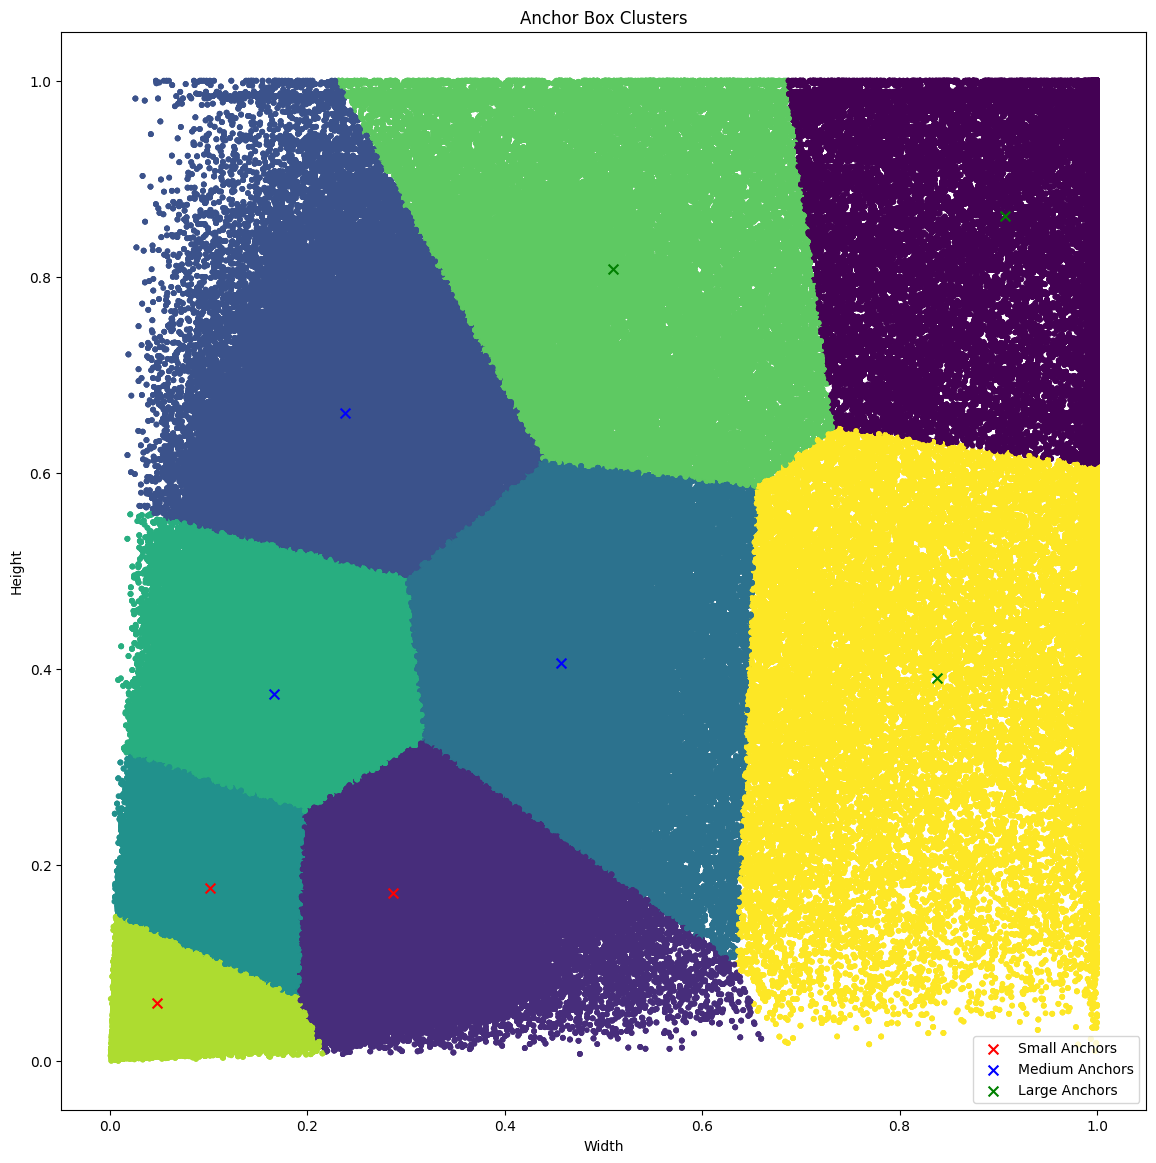

In [12]:
# 시각화
plt.figure(figsize=(14, 14))
plt.scatter(bboxes[:, 0], bboxes[:, 1], c=kmeans.labels_, s=10, cmap='viridis')
plt.scatter(anchor_box_list[0][:, 0], anchor_box_list[0][:, 1], c='red', s=50, marker='x', label='Small Anchors')
plt.scatter(anchor_box_list[1][:, 0], anchor_box_list[1][:, 1], c='blue', s=50, marker='x', label='Medium Anchors')
plt.scatter(anchor_box_list[2][:, 0], anchor_box_list[2][:, 1], c='green', s=50, marker='x', label='Large Anchors')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Anchor Box Clusters')
plt.legend()
plt.show()